In [1]:
import sys
import os
import torch

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from equivariant_pose_graph.utils.color_utils import color_gradient

from pytorch3d.transforms import Transform3d, Rotate, Translate

from torch.utils.data import DataLoader

from equivariant_pose_graph.utils.se3 import random_se3
from pytorch3d.transforms import Transform3d
from pytorch_lightning.utilities.seed import seed_everything

%load_ext autoreload
%autoreload 2

In [2]:
def toDisplay(x, target_dim = None):
    while(target_dim is not None and x.dim() > target_dim):
        x = x[0]
    return x.detach().cpu().numpy()

In [3]:
from pytorch3d.transforms import Transform3d,Rotate, rotation_6d_to_matrix, se3_exp_map
from equivariant_pose_graph.utils.se3 import *
from equivariant_pose_graph.utils.display import *
from equivariant_pose_graph.dataset.point_cloud_dataset import PointCloudDataset
from equivariant_pose_graph.dataset.point_cloud_data_module import MultiviewDataModule

In [28]:
from equivariant_pose_graph.models.transformer_flow import ResidualFlow_DiffEmbTransformer
from equivariant_pose_graph.models.multimodal_transformer_flow import Multimodal_ResidualFlow_DiffEmbTransformer, Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_eval_init import EquivarianceTestingModule
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_multimodal import EquivarianceTrainingModule, EquivarianceTrainingModule_WithPZCondX


# # add smooth
# # place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-09_010827/residual_flow_occlusion/2r9q5ig3/checkpoints/epoch_427_global_step_107000.ckpt"

# # division smooth
# # place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-09_010903/residual_flow_occlusion/26up1fdq/checkpoints/epoch_999_global_step_250000.ckpt"

# # 2 rack overfit
# place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-15_145531/residual_flow_occlusion/26qo410g/checkpoints/epoch_3_global_step_1000.ckpt"

# # 1 rack overfit
# # place_checkpoint_file="/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-03-15_155047/residual_flow_occlusion/37cs1pnj/checkpoints/epoch_3_global_step_1000.ckpt"



# Trained TP on smoothed p(z|Y). This doesn't have p(z|X)
# last model checkpoint
# place_checkpoint_file_pzY = "/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-04-15_084037/residual_flow_occlusion/2acgj586/checkpoints/epoch_799_global_step_200000.ckpt"
# somewhere in the middle
place_checkpoint_file_pzY = "/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-04-13_084530/residual_flow_occlusion/3tx2a873/checkpoints/epoch_291_global_step_73000.ckpt"

# Trained p(z|X) to match unsmoothed p(z|Y)
place_checkpoint_file_pzX = "/home/jwang/code/equivariant_pose_graph/logs/residual_flow_occlusion/2023-04-13_083720/residual_flow_occlusion/837jvibj/checkpoints/epoch_51_global_step_13000.ckpt"



def load_model(place_checkpoint_file, has_pzX):
    inner_network = ResidualFlow_DiffEmbTransformer(
                        emb_nn='dgcnn', return_flow_component=True, center_feature=True,
                        inital_sampling_ratio=1, input_dims=4)
    place_nocond_network = Multimodal_ResidualFlow_DiffEmbTransformer(
                        inner_network, gumbel_temp=1, center_feature=True)
    place_network = Multimodal_ResidualFlow_DiffEmbTransformer_WithPZCondX(
                        place_nocond_network, encoder_type="2_dgcnn", sample_z=False)
    place_nocond_model = EquivarianceTrainingModule(
        place_nocond_network,
        lr=1e-4,
        image_log_period=100,
        weight_normalize='softmax', #'l1',
        softmax_temperature=1
    )
    
    if has_pzX:
        place_model = EquivarianceTrainingModule_WithPZCondX(
            place_network,
            place_nocond_model,
        )
    else:
        place_model = place_nocond_model

    place_model.cuda()
    place_model.load_state_dict(torch.load(place_checkpoint_file)['state_dict']);
    return place_model

pzY_model = load_model(place_checkpoint_file_pzY, has_pzX=False)
pzX_model = load_model(place_checkpoint_file_pzX, has_pzX=True)




In [29]:
# todo merge
pzX_model.model.tax_pose = pzY_model.model.tax_pose

torch.save({"state_dict": pzX_model.state_dict()}, "TEST.ckpt")

In [21]:
place_model = load_model("TEST.ckpt", has_pzX=True)

In [17]:
uh = torch.load(place_checkpoint_file_pzX)

In [18]:
uh.keys()

dict_keys(['state_dict'])

In [8]:
pzX_model

EquivarianceTrainingModule_WithPZCondX(
  (model): Multimodal_ResidualFlow_DiffEmbTransformer(
    (tax_pose): ResidualFlow_DiffEmbTransformer(
      (emb_nn_action): DGCNN(
        (conv1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv5): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn5): BatchNorm2d(512, eps=1e-05, mo

In [22]:
mug0_dm = MultiviewDataModule(
        dataset_root='/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
        test_dataset_root='/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
#         dataset_index=[0],
        dataset_index="None",
        action_class=0,
        anchor_class=1,
        dataset_size=1000,
        rotation_variance=np.pi/180 * 180,
        translation_variance=0.5,
        batch_size=1,
        num_workers=1,
        cloud_type="teleport",
        num_points=1024,
        overfit=False,
        num_overfit_transforms=1,
        seed_overfit_transforms=True,
        set_Y_transform_to_identity=True,
        synthetic_occlusion=False,
        ball_radius=0.1
)
mug0_dm.setup()


TRAIN Dataset
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99928_teleport_obj_points.npz
VAL Dataset
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/99928_teleport_obj_points.npz


In [23]:
from equivariant_pose_graph.utils.error_metrics import get_2rack_errors, print_rack_errors
import gc

In [24]:
verbose = False

get_rack_errors = get_2rack_errors

j = 0
dataloader = mug0_dm.train_dataloader()

place_model.eval()


pzX_R_errors = []
pzX_t_errors = []
pzX_under_pzY_prob_action = []
pzX_under_pzY_prob_anchor = []
pzX_under_pzX_prob_action = []
pzX_under_pzX_prob_anchor = []
pzX_i_action = []
pzX_i_anchor = []

BATCH_SIZE = 100

for data in dataloader:
    print(j)
    points_action = data['points_action'].cuda().detach()
    points_anchor = data['points_anchor'].cuda().detach()

    points_action_trans = data['points_action_trans'].cuda().detach()
    points_anchor_trans = data['points_anchor_trans'].cuda().detach()

    points_action_onetrans = data['points_action_onetrans'].cuda().detach()
    points_anchor_onetrans = data['points_anchor_onetrans'].cuda().detach()

    T0 = Transform3d(matrix=data['T0'].cuda().detach())
    T1 = Transform3d(matrix=data['T1'].cuda().detach())
    T2 = Transform3d(matrix=data['T2'].cuda().detach())
    
#     torch.manual_seed(0)
    for i in range(BATCH_SIZE):
        # For some reason, setting place_model.train() here and setting place_model.eval() in the p(z|X) sampling
        # section 4 lines below makes the eval pred_T_action's drift over time
        val_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)
        pzX_logits = val_res['flow_components']['goal_emb_cond_x'][0,0].detach()
        pzY_logits = val_res['flow_components']['goal_emb'][0,0].detach()

        pred_T_action = val_res['pred_T_action']
        error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="batch_min_rack", verbose=verbose)
        pzX_R_errors.append(error_R_mean)
        pzX_t_errors.append(error_t_mean)
        
        i_action = val_res['flow_components']['trans_sample_action'].argmax().detach().item()
        i_anchor = val_res['flow_components']['trans_sample_anchor'].argmax().detach().item()
        pzX_i_action.append(i_action)
        pzX_i_anchor.append(i_anchor)

        torch.set_printoptions(precision=2, sci_mode=False)
        if j == 0:
            print("y mug", torch.topk(F.softmax(pzY_logits[:1024]), 10)[0])
            print("y mug", torch.topk(F.softmax(pzY_logits[:1024]), 10)[1])
            print("y rack", torch.topk(F.softmax(pzY_logits[1024:]), 10)[0])
            print("y rack", torch.topk(F.softmax(pzY_logits[1024:]), 10)[1])
            print("x mug", torch.topk(F.softmax(pzX_logits[:1024]), 10)[0])
            print("x mug", torch.topk(F.softmax(pzX_logits[:1024]), 10)[1])
            print("x rack", torch.topk(F.softmax(pzX_logits[1024:]), 10)[0])
            print("x rack", torch.topk(F.softmax(pzX_logits[1024:]), 10)[1])
    
        print('out here ACTION', val_res['flow_components']['trans_sample_action'].argmax().detach().item(), 'wth prob', F.softmax(pzX_logits[:1024], dim=-1).detach()[val_res['flow_components']['trans_sample_action'].argmax().detach().item()].item())
        print('where max is', F.softmax(pzX_logits[:1024], dim=-1).detach().max())
        print('out here', val_res['flow_components']['trans_sample_anchor'].argmax().detach().item(), 'wth prob', F.softmax(pzX_logits[1024:], dim=-1).detach()[val_res['flow_components']['trans_sample_anchor'].argmax().detach().item()].item())
        pzX_under_pzY_prob_action.append(F.softmax(pzY_logits[:1024], dim=-1).detach()[i_action].item())
        pzX_under_pzY_prob_anchor.append(F.softmax(pzY_logits[1024:], dim=-1).detach()[i_anchor].item())

        pzX_under_pzX_prob_action.append(F.softmax(pzX_logits[:1024], dim=-1).detach()[i_action].item())
        pzX_under_pzX_prob_anchor.append(F.softmax(pzX_logits[1024:], dim=-1).detach()[i_anchor].item())

        for value in val_res.values():
            del value
        del val_res
        del pred_T_action
        del pzY_logits
        del pzX_logits

        j += 1

    # Delete everything
    points_action_trans = None
    points_anchor_trans = None
    data = None
    points_action_onetrans = None
    points_anchor_onetrans = None
    gc.collect()

    if j >= BATCH_SIZE*10:
        break
del dataloader

X_to_Y_importance_weights = [mY*rY / (mX*rX) for mY, rY, mX, rX in zip(pzX_under_pzY_prob_action, pzX_under_pzY_prob_anchor, pzX_under_pzX_prob_action, pzX_under_pzX_prob_anchor)]



0


/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprec

y mug tensor([0.27, 0.26, 0.19, 0.12, 0.04, 0.04, 0.03, 0.02, 0.01, 0.01],
       device='cuda:0')
y mug tensor([174, 595, 713, 718, 446,  53, 600, 633, 905, 949], device='cuda:0')
y rack tensor([    0.98,     0.02,     0.00,     0.00,     0.00,     0.00,     0.00,
            0.00,     0.00,     0.00], device='cuda:0')
y rack tensor([ 41, 912, 774, 937, 363, 467, 295, 935, 343, 939], device='cuda:0')
x mug tensor([0.15, 0.13, 0.10, 0.09, 0.09, 0.06, 0.05, 0.04, 0.04, 0.03],
       device='cuda:0')
x mug tensor([174, 411, 664, 713, 595, 905, 852, 446,  12, 536], device='cuda:0')
x rack tensor([0.89, 0.05, 0.02, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00],
       device='cuda:0')
x rack tensor([ 41, 912, 446, 774, 484, 554, 937,  73, 976, 862], device='cuda:0')
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here

out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='cuda:0')
out here 41 wth prob 0.886922299861908
out here ACTION 174 wth prob 0.15094226598739624
where max is tensor(0.15, device='

out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='c

out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
out here ACTION 141 wth prob 0.3146970272064209
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9702028036117554
200
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, devic

out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='cuda:0')
out here 42 wth prob 0.9741693139076233
out here ACTION 813 wth prob 0.6374266743659973
where max is tensor(0.64, device='c

out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='c

out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='cuda:0')
out here 41 wth prob 0.5414101481437683
out here ACTION 131 wth prob 0.6251968145370483
where max is tensor(0.63, device='c

out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, device='cuda:0')
out here 885 wth prob 0.5966190099716187
out here ACTION 664 wth prob 0.4935609996318817
where max is tensor(0.49, de

out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, d

out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, device='cuda:0')
out here 42 wth prob 0.7515642642974854
out here ACTION 134 wth prob 0.28428152203559875
where max is tensor(0.28, d

out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, device='cuda:0')
out here 41 wth prob 0.9011924266815186
out here ACTION 713 wth prob 0.30624622106552124
where max is tensor(0.31, d

out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='c

out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='cuda:0')
out here 41 wth prob 0.7627727389335632
out here ACTION 138 wth prob 0.4346639811992645
where max is tensor(0.43, device='c

out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, device='cuda:0')
out here 41 wth prob 0.6855766177177429
out here ACTION 709 wth prob 0.27879098057746887
where max is tensor(0.28, d

out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0

out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0.13, device='cuda:0')
out here 804 wth prob 0.28473344445228577
out here ACTION 136 wth prob 0.1304905116558075
where max is tensor(0

In [25]:
np.array(pzX_under_pzX_prob_action).max()

0.6374266743659973

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

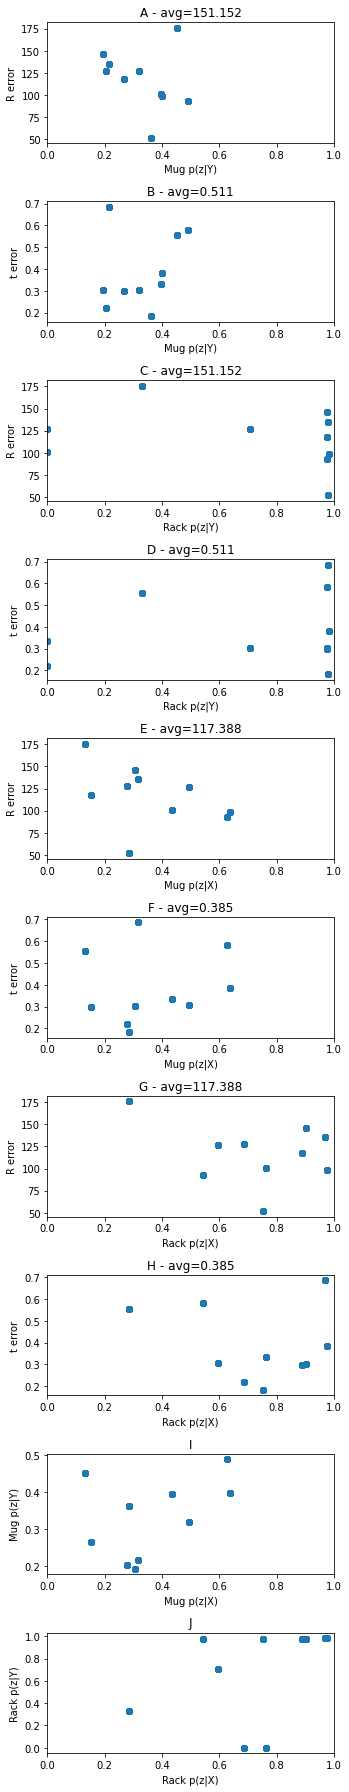

In [27]:
def scatter(x, y, xlabel, ylabel, title, ax, weight_in_title=False, plot_line=False, importance_weights=None):
    ax.scatter(x, y, alpha=0.1) #s=[np.sqrt(p)*100 for p in x])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([0,1])
    if weight_in_title:
        if importance_weights is None:
            weighted_avg = sum(y) / len(x)
        else:
            weighted_avg = sum([w * val for w, val in zip(importance_weights, y)]) / len(x)
        title = f"{title} - avg={weighted_avg:.3f}"
    if plot_line:
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m*np.array(x)+b, c='orange')

    ax.set_title(title)
    
fig, axs = plt.subplots(10, 1)
fig.set_figheight(25)
fig.set_figwidth(5)

    

scatter(pzX_under_pzY_prob_action, pzX_R_errors, "Mug p(z|Y)", "R error", "A", axs[0], weight_in_title=True, importance_weights=X_to_Y_importance_weights)
scatter(pzX_under_pzY_prob_action, pzX_t_errors, "Mug p(z|Y)", "t error", "B", axs[1], weight_in_title=True, importance_weights=X_to_Y_importance_weights)

scatter(pzX_under_pzY_prob_anchor, pzX_R_errors, "Rack p(z|Y)", "R error", "C", axs[2], weight_in_title=True, importance_weights=X_to_Y_importance_weights)
scatter(pzX_under_pzY_prob_anchor, pzX_t_errors, "Rack p(z|Y)", "t error", "D", axs[3], weight_in_title=True, importance_weights=X_to_Y_importance_weights)

scatter(pzX_under_pzX_prob_action, pzX_R_errors, "Mug p(z|X)", "R error", "E", axs[4], weight_in_title=True)
scatter(pzX_under_pzX_prob_action, pzX_t_errors, "Mug p(z|X)", "t error", "F", axs[5], weight_in_title=True)

scatter(pzX_under_pzX_prob_anchor, pzX_R_errors, "Rack p(z|X)", "R error", "G", axs[6], weight_in_title=True)
scatter(pzX_under_pzX_prob_anchor, pzX_t_errors, "Rack p(z|X)", "t error", "H", axs[7], weight_in_title=True)

scatter(pzX_under_pzX_prob_action, pzX_under_pzY_prob_action, "Mug p(z|X)", "Mug p(z|Y)", "I", axs[8]) #, plot_line=True)
scatter(pzX_under_pzX_prob_anchor, pzX_under_pzY_prob_anchor, "Rack p(z|X)", "Rack p(z|Y)", "J", axs[9]) #, plot_line=True)

fig.tight_layout()
fig.show()


In [22]:
pzX_under_pzX_prob_action

[0.3657207190990448,
 0.03873129561543465,
 0.3657207190990448,
 0.1615903228521347,
 0.1615903228521347,
 0.3657207190990448,
 0.3657207190990448,
 0.1615903228521347,
 0.1615903228521347,
 0.1615903228521347,
 0.3657207190990448,
 0.3657207190990448,
 0.1615903228521347,
 0.06091359257698059,
 0.3657207190990448,
 0.3657207190990448,
 0.3657207190990448,
 0.027315683662891388,
 0.005845248233526945,
 0.1615903228521347,
 0.1615903228521347,
 0.3657207190990448,
 0.007723281625658274,
 0.3657207190990448,
 0.0033185549546033144,
 0.027315683662891388,
 0.3657207190990448,
 0.3657207190990448,
 0.05660831928253174,
 0.006033448502421379,
 0.3657207190990448,
 0.05824156850576401,
 0.05660831928253174,
 0.1615903228521347,
 0.06091359257698059,
 0.1615903228521347,
 0.0074586812406778336,
 0.05824156850576401,
 0.03873129561543465,
 0.3657207190990448,
 0.3657207190990448,
 0.06091359257698059,
 0.3657207190990448,
 0.3657207190990448,
 0.1615903228521347,
 0.0066919634118676186,
 0.028

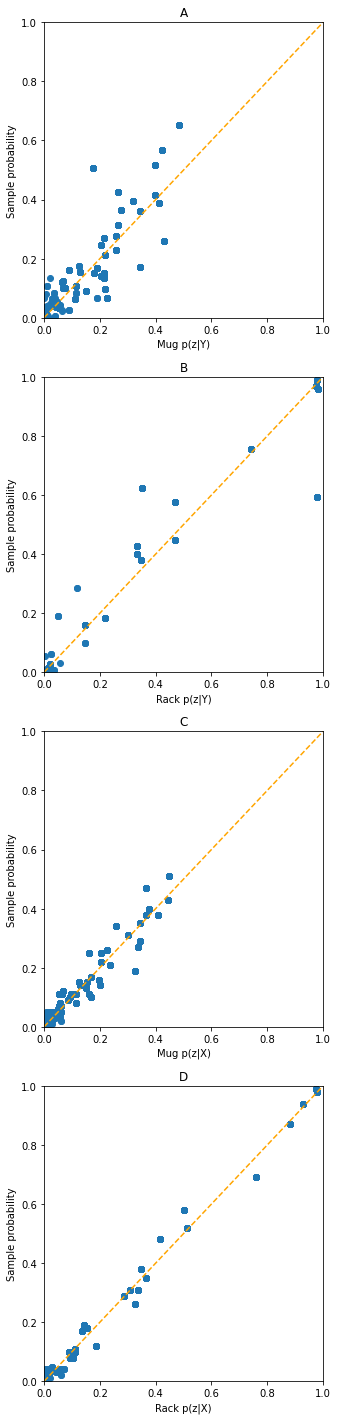

In [23]:
def plot_cumsum(sample_probs, point_is, xlabel, ylabel, title, ax, importance_weights=None):
    line = np.linspace(0, 1, 10)
    ax.plot(line, line, '--', c='orange')
    
    # BATCH_SIZE is defined in a previous cell
    
    x = []
    y = []
    for batch_i in range(0, len(point_is), BATCH_SIZE):
        batch_point_is = point_is[batch_i:batch_i+BATCH_SIZE]
        for i in np.unique(batch_point_is):
            list_index = np.where(np.array(batch_point_is) == i)[0]
            avg_dist_prob = np.array(sample_probs)[list_index+batch_i].mean()
            sample_prob = len(list_index)/BATCH_SIZE
            if importance_weights is not None:
                avg_importance_weight = np.array(importance_weights)[list_index+batch_i].mean()
                sample_prob = sample_prob * avg_importance_weight
            x.extend([avg_dist_prob]*len(list_index))
            y.extend([sample_prob]*len(list_index))
    ax.scatter(x, y)
    
#     heatmap, xedges, yedges = np.histogram2d(x, y, bins=10, range=[[0,1],[0,1]])
#     extent = [0,1,0,1]
#     ax.imshow(heatmap.T, extent=extent, origin='lower')
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

        
        
        
        
#     WIDTH = 0.1
#     bins = np.arange(0, 1+WIDTH, WIDTH)
#     if importance_weights is not None:
#         sample_probs = np.array([w * val for w, val in zip(importance_weights, sample_probs)])
#     vals, bins = np.histogram(sample_probs, bins)
#     vals = vals / len(sample_probs)
#     ax.bar(bins[:-1], vals, width=WIDTH, align='edge')
#     ax.set_xlim([0,1])
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)
    
fig, axs = plt.subplots(4, 1)
fig.set_figheight(25)
fig.set_figwidth(5)

plot_cumsum(pzX_under_pzY_prob_action, pzX_i_action, "Mug p(z|Y)", "Sample probability", "A", axs[0], importance_weights=X_to_Y_importance_weights)
plot_cumsum(pzX_under_pzY_prob_anchor, pzX_i_anchor, "Rack p(z|Y)", "Sample probability", "B", axs[1], importance_weights=X_to_Y_importance_weights)
plot_cumsum(pzX_under_pzX_prob_action, pzX_i_action, "Mug p(z|X)", "Sample probability", "C", axs[2])
plot_cumsum(pzX_under_pzX_prob_anchor, pzX_i_anchor, "Rack p(z|X)", "Sample probability", "D", axs[3])
    
    

In [13]:
len(pzX_i_anchor)

100

In [14]:
do dat break

SyntaxError: invalid syntax (<ipython-input-14-6fb8949470d5>, line 1)

In [ ]:
def plot(demo_action, demo_anchor, pred_action, pred_anchor):
    def scatter(fig, pts, col):
        fig.add_trace(
            go.Scatter3d(
                x = pts[:,0], 
                y = pts[:,1], 
                z = pts[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                marker=dict(
                    opacity=1
                )
            ), 
            row=1,col=col
        )
        
    fig = go.FigureWidget(
        make_subplots(
            column_widths=[0.5, 0.5],
            row_heights=[1],
            rows=1, cols=2,
            specs=[[{'type': 'surface'}, {'type': 'surface'}]],
            subplot_titles=["demo", "prediction"]
        )
    )
    
    scatter(fig, demo_action, 1)
    scatter(fig, demo_anchor, 1)
    scatter(fig, pred_action, 2)
    scatter(fig, pred_anchor, 2)
    
    return fig



get_rack_errors = get_2rack_errors

j = 0
dataloader = mug0_dm.train_dataloader()

for data in dataloader:
    points_action = data['points_action'].cuda().detach()
    points_anchor = data['points_anchor'].cuda().detach()

    points_action_trans = data['points_action_trans'].cuda().detach()
    points_anchor_trans = data['points_anchor_trans'].cuda().detach()

    points_action_onetrans = data['points_action_onetrans'].cuda().detach()
    points_anchor_onetrans = data['points_anchor_onetrans'].cuda().detach()
    
    T0 = Transform3d(matrix=data['T0'].cuda().detach())
    T1 = Transform3d(matrix=data['T1'].cuda().detach())
    T2 = Transform3d(matrix=data['T2'].cuda().detach())
    
    place_model.training = True
    train_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)

    pred_T_action = train_res['pred_T_action']
    error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="batch_min_rack", verbose=verbose)

    place_model.training = False
    val_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)

    pred_T_action = val_res['pred_T_action']
    error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="batch_min_rack", verbose=verbose)

    
    fig = plot(
                toDisplay(points_action_onetrans[0]), 
                toDisplay(points_anchor_onetrans[0]), 
                toDisplay(pred_T_action.transform_points(points_action_trans)[0]), 
                toDisplay(points_anchor_trans[0]),
#                 toDisplay(pred_T_action.inverse().transform_points(points_anchor_onetrans)[0]),
    )
    
    print(f"R error: {error_R_mean:.2f}")
    print(f"t error: {error_t_mean:.2f}")

    for value in train_res.values():
        del value
    for value in val_res.values():
        del value
    del train_res
    del val_res
    del pred_T_action

    j += 1

    # Delete everything
    points_action_trans = None
    points_anchor_trans = None
    data = None
    points_action_onetrans = None
    points_anchor_onetrans = None
    gc.collect()

    break
del dataloader


fig


In [ ]:
plt.scatter([p.cpu() for p in pzX_under_pzX_prob_action], pzX_R_errors)

sum([p.cpu()*err for p, err in zip(pzX_under_pzX_prob_action, pzX_R_errors)])/len(pzX_R_errors)

## look at top 3 z samples

In [ ]:
get_rack_errors = get_2rack_errors
dataloader = mug0_dm.train_dataloader()

for data in dataloader:
    points_action = data['points_action'].cuda().detach()
    points_anchor = data['points_anchor'].cuda().detach()

    points_action_trans = data['points_action_trans'].cuda().detach()
    points_anchor_trans = data['points_anchor_trans'].cuda().detach()

    points_action_onetrans = data['points_action_onetrans'].cuda().detach()
    points_anchor_onetrans = data['points_anchor_onetrans'].cuda().detach()
    
    T0 = Transform3d(matrix=data['T0'].cuda().detach())
    T1 = Transform3d(matrix=data['T1'].cuda().detach())
    T2 = Transform3d(matrix=data['T2'].cuda().detach())
    break

place_model.train()
train_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)
pzY_logits = train_res['flow_components']['goal_emb'][0,0]

place_model.eval()
val_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)
pzX_logits = val_res['flow_components']['goal_emb_cond_x'][0,0]

In [ ]:
def vis_top_z(full_logits, points_action, points_anchor, k=3, do_rack=True, show_point_cloud=True, name=""):
    # These arrays shouldn't have the batch in them
    assert full_logits.ndim == 1
    
    action_pts = toDisplay(points_action[0])
    anchor_pts = toDisplay(points_anchor[0])
    
    if do_rack:
        logits = full_logits[1024:]
        point_cloud = anchor_pts
    else:
        logits = full_logits[:1024]
        point_cloud = action_pts
        
    top_probs, top_indices = torch.topk(F.softmax(logits, dim=-1), k)

    fig = go.FigureWidget(
            make_subplots(
                column_widths=[1],
                row_heights=[1],
                rows=1, cols=1,
                specs=[[{'type': 'surface'}]],
            )
        )
    
    if show_point_cloud:
        fig.add_trace(
            go.Scatter3d(
                x = action_pts[:,0], 
                y = action_pts[:,1], 
                z = action_pts[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                marker=dict(
                    opacity=0.05
                )
            ), 
            row=1,col=1
        )

        fig.add_trace(
            go.Scatter3d(
                x = anchor_pts[:,0], 
                y = anchor_pts[:,1], 
                z = anchor_pts[:,2], 
                mode = 'markers',
                hoverinfo = 'none',
                marker=dict(
                    opacity=0.05
                )
            ), 
            row=1,col=1
        )
    
    
    def SetColor(x):
        if(x < 0.2):
            return "red"
        elif(x >= 0.2 and x <= 0.4):
            return "yellow"
        elif(x > 0.4):
            return "green"
        
    for top_num, (prob, index) in enumerate(zip(top_probs, top_indices)):
        pt = point_cloud[index]
        fig.add_trace(
            go.Scatter3d(
                x = [pt[0]], 
                y = [pt[1]], 
                z = [pt[2]], 
                mode = 'markers',
                hoverinfo = 'none',
                name=f"top{top_num+1}",
                marker=dict(
                    color=[SetColor(prob)]
                )
            ), 
            row=1, col=1
        )
        
#     error_R_mean, error_t_mean = get_rack_errors(pred_T_action, T0, T1, mode="batch_min_rack", verbose=verbose)
        
    
    
    
    return fig
fig = vis_top_z(pzX_logits, train_res['pred_points_action'], points_anchor_trans, k=10, do_rack=False, show_point_cloud=True, name="")

fig



In [ ]:
for value in train_res.values():
    del value
for value in val_res.values():
    del value
del train_res
del val_res
del pzY_logits
del pzX_logits

In [ ]:
train_res['pred_points_action'].shape

# Memory allocation checks

In [ ]:
# print("Memory allocated before:", torch.cuda.memory_allocated())
# verbose = True

# get_rack_errors = get_2rack_errors

# for j in range(1):
#     for data in mug0_dm.train_dataloader():
#         points_action_trans = data['points_action_trans'].cuda().detach()
#         points_anchor_trans = data['points_anchor_trans'].cuda().detach()

#         points_action_onetrans = data['points_action_onetrans'].cuda().detach()
#         points_anchor_onetrans = data['points_anchor_onetrans'].cuda().detach()

#         place_model.train()
#         train_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)

#         place_model.eval()
#         val_res = place_model.get_transform(points_action_trans, points_anchor_trans, points_action_onetrans, points_anchor_onetrans)

#         test1 = {
#                     'flow_action': val_res['flow_components']['flow_action'],
#                 }
#         points_action_trans = None
#         points_anchor_trans = None
#         data = None
#         points_action_onetrans = None
#         points_anchor_onetrans = None
#         gc.collect()
#         for value in train_res.values():
#             del value
#         for value in val_res.values():
#             del value
#         del train_res
#         del val_res
#         break
        
# print("Memory allocated after:", torch.cuda.memory_allocated())


In [ ]:
# torch.cuda.synchronize()
# print(torch.cuda.memory_summary())